In [10]:
from skimage.morphology import skeletonize, medial_axis
from skimage import data
import matplotlib.pyplot as plt
from skimage.util import invert
# imports
import os, sys
import numpy as np
import tensorflow as tf
import voxelmorph as vxm
import neurite as ne
assert tf.__version__.startswith('2.'), 'This tutorial assumes Tensorflow 2.0+'
import h5py
from utilitary import *


In [2]:
hf = h5py.File("../20201112_090735_SJR14.3_pan_w3_s1_IAA_30ms_1.8laser.h5", "r")

In [8]:
keys = hf.keys()
# Some keys are empty. Remove them
use_key = remove_empty_key(keys, hf)

x,y,z = hf.get('0')['frame'][0].shape      
nb_entries = len(use_key) 
list_keys = list(use_key)

In [11]:
# Calculate the max intensity projection according to axis = 2 (z-axis)
# MIP shape : (572, 512, 512, 3) : All volumes, 3 RGB values, intensity values are divided by 255
# MIP_avg shape : (572, 512, 512) : All volumes, mean RGB values, intensity values are divided by 255
MIP, MIP_avg = to_MIP(hf, list_keys, axis = 2)

Text(0.5, 1.0, 'MIP avg, frame 0')

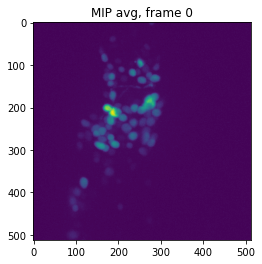

In [23]:
# Visualize MIP_avg of frame 0
plt.imshow(MIP_avg[0])
plt.title('MIP avg, frame 0')

In [14]:
# Find the contours of all "volumes" of MIP_avg
# contours : binary {0,1}
# all_ret : all the threshold used
contours, all_ret = find_contour(MIP_avg)

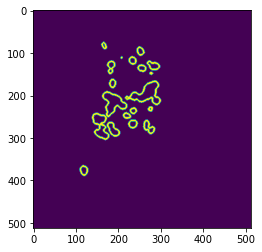

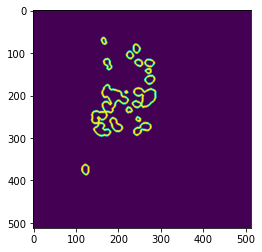

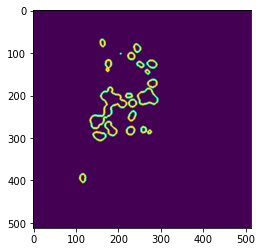

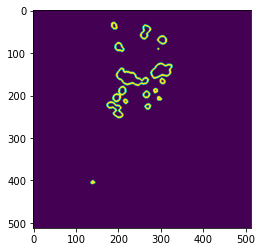

In [15]:
# Some visualisation for fun
for i in range(4):
    plt.figure()
    plt.imshow(contours[i])

In [16]:
# Split train-validation set
# 80% train - 20% validation
ratio = 0.8
keys_random = np.random.permutation(nb_entries)
keys_train = keys_random[:int(nb_entries * ratio)]
keys_test  = keys_random[int(nb_entries * ratio):]

# Train on the contours
Contours_train = contours[keys_train]
# Test on the "original" MIP_avg
MIP_avg_test = MIP_avg[keys_test]

Instructions for updating:
Use fn_output_signature instead
Epoch 1/4
110/110 [==============================] - 120s 1s/step - loss: 0.0228 - vxm_dense_transformer_loss: 0.0228 - vxm_dense_flow_loss: 0.0089
Epoch 2/4
110/110 [==============================] - 123s 1s/step - loss: 0.0172 - vxm_dense_transformer_loss: 0.0171 - vxm_dense_flow_loss: 0.1185
Epoch 3/4
110/110 [==============================] - 120s 1s/step - loss: 0.0159 - vxm_dense_transformer_loss: 0.0157 - vxm_dense_flow_loss: 0.1722
Epoch 4/4
110/110 [==============================] - 118s 1s/step - loss: 0.0157 - vxm_dense_transformer_loss: 0.0155 - vxm_dense_flow_loss: 0.1863


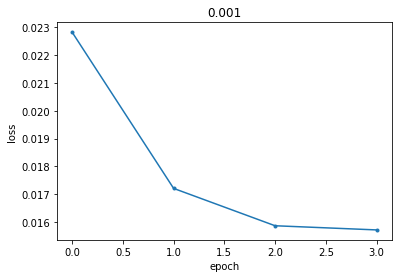

Epoch 1/4
110/110 [==============================] - 114s 1s/step - loss: 0.0197 - vxm_dense_transformer_loss: 0.0174 - vxm_dense_flow_loss: 0.0223
Epoch 2/4
110/110 [==============================] - 120s 1s/step - loss: 0.0185 - vxm_dense_transformer_loss: 0.0172 - vxm_dense_flow_loss: 0.0127
Epoch 3/4
110/110 [==============================] - 121s 1s/step - loss: 0.0180 - vxm_dense_transformer_loss: 0.0167 - vxm_dense_flow_loss: 0.0124
Epoch 4/4
110/110 [==============================] - 118s 1s/step - loss: 0.0187 - vxm_dense_transformer_loss: 0.0175 - vxm_dense_flow_loss: 0.0125


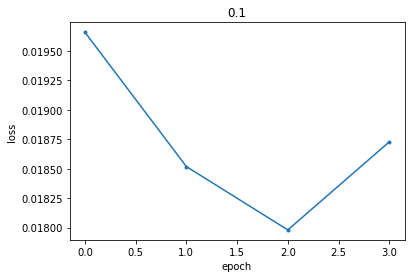

In [17]:
# UNET architecture

vol_shape = (x, y) # 32 slices
nb_features = [
    [16, 32, 32, 32],             # encoder
    [32, 32, 32, 32, 32, 16, 16]  # decoder
]

# build vxm network using VxmDense
vxm_model = vxm.networks.VxmDense(vol_shape, nb_features, int_steps=0);

# Losses : MSE + smoothness (regularization) 
losses = ['mse', vxm.losses.Grad('l2').loss]

# Regularizer
lambdas = np.logspace(-3,-1,2)
for lambda_ in lambdas :

    loss_weights = [1, lambda_]
    
#     vxm_model = tf.keras.utils.multi_gpu_model(vxm_model, gpus=2)
    # Adam optimizer learning rate
    vxm_model.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-4), loss=losses, loss_weights=loss_weights)
    
    # Training
    train_generator = vxm_data_generator(Contours_train, batch_size = 1)
    hist = vxm_model.fit(train_generator, epochs=4, steps_per_epoch= 110, verbose=1);
    # Visualize the losses
    plot_history(hist, save_name = str(lambda_))
    title = "weights" + str(lambda_) + ".keras"
    # If it looks ok => save the weights
    vxm_model.save_weights(title)

In [18]:
# Load the best weights found
title = "weights" + str(0.001) + ".keras"
vxm_model.load_weights(title)

# Validation set generator
val_generator = vxm_data_generator(MIP_avg_test, batch_size = 15)
val_input, _ = next(val_generator)
our_val_pred = vxm_model.predict(val_input);

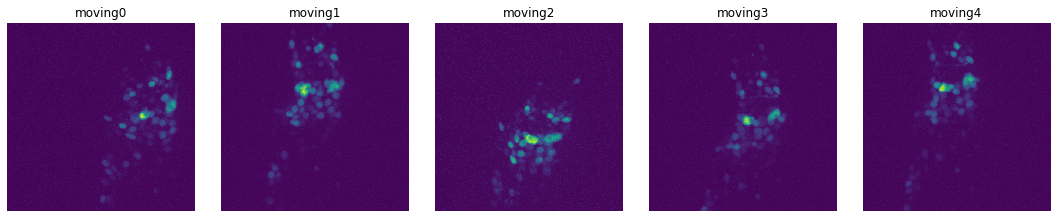

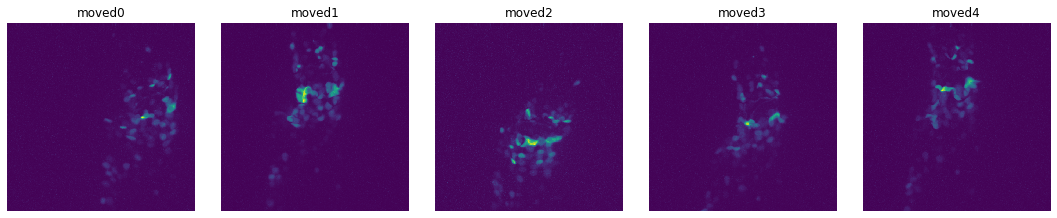

In [21]:
# Plot some MIP_avg moving & moved, to see the results
moving = np.squeeze(val_input[0])
fixed = np.squeeze(val_input[1])
moved = np.squeeze(our_val_pred[0])

a = [moved[i, ...] for i in range(5)]
b = [moving[i, ...] for i in range(5)]

titles1 = ['moving' + str(i) for i in range(5)]
titles2 = ['moved' + str(i) for i in range(5)]
# Moving
ne.plot.slices(b, titles=titles1, do_colorbars=True);
# Moved
ne.plot.slices(a, titles=titles2, do_colorbars=True);

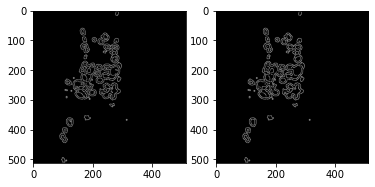

In [87]:
# Another segmentation method : Canny
fig, (ax1, ax2) = plt.subplots(ncols=2)
im_ok = im.astype(np.uint8)
edges = cv2.Canny(im_ok,0.5,1)
ax1.imshow(edges,cmap = 'gray')

im_ok = im.astype(np.uint8)
blur = cv2.GaussianBlur(im_ok,(5,5),0)
edges = cv2.Canny(blur,0.5,1)
ax2.imshow(edges,cmap = 'gray')